In [341]:
from __future__ import print_function

import time
import sys
import os

import numpy as np

# from util import *

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA

class LayerKmeans(object):

    def __init__(self, kernel_size=2, n_clusters=5):
        self.ks = kernel_size
        self.nc = n_clusters
        self.ready = False
    
    def train(self, images):

        def cluster(images):
            patches = _gather_patches(images, self.ks)
            kmeans = KMeans(n_clusters=self.nc)
            kmeans.fit(patches)
            return kmeans, patches

        time_start = time.clock()
        kmeans_L1, patches_L1 = cluster(images)
        print('kmeans on L1 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))

        images_ds = _downsample(images, self.ks)
        print('down sample shape: ' + str(images_ds.shape))

        time_start = time.clock()
        kmeans_L2, patches_L2 = cluster(images_ds)
        print('kmeans on L2 clustering cost: %.3f sec' % 
                (time.clock() - time_start, ))

        label_L2 = np.expand_dims(kmeans_L2.labels, axis=1)
        label_L2 = np.tile(label_L2, [1,ks*ks])
        label_L2 = np.reshape(label_L2, [-1])

        Saak = [[None] * self.nc for i in range(self.nc)]

        for i in range(self.nc):
            for j in range(self.nc):
                ind = np.logical_and(kmeans_L1.labels_ == i,
                        label_L2 == j)
                patches = patches_L1[ind,:]
                Saak[i][j] = SaakStage(patches, self.ks)

        self.kmeans = [kmeans_L1, kmeans_L2]
        print('kmeans done!')

    def test_patches(self, patches, layer):
        # assert self.ready
        assert layer == 1 or layer == 2
        return self.kmeans[layer - 1].predict(patches)

    def test_images(self, images):
        # get images shape
        n, h, w, ch = images.shape
        ks = self.ks
        nc = self.nc

        # get downsampled images
        images_ds = _downsample(images, ks)
        # n_ds, h_ds, w_ds, ch_ds = images_ds.shape
        
        # get L2
        patches_L2 = _gather_patches(images_ds, ks)
        # indices_L2 = np.arange(len(patches_L2))
        label_L2 = self.test_patches(patches_L2, layer=2)
        label_L2_up = np.expand_dims(label_L2, axis=1)
        label_L2_up = np.tile(label_L2, [1, ks*ks])
        # np.save('p1_3.npy', label_L2_up)
        label_L2_up = np.reshape(label_L2_up, [-1])
        # label_L2_reshaped = _reshape_patches(label_L2, h, w, ch)
        print('label L2 shape: ' + str(label_L2.shape))
        print('label L2 up shape: ' + str(label_L2_up.shape))

        # get L1
        patches_L1 = _gather_patches(images, ks)
        # indices_L1 = np.arange(len(patches_L1))
        label_L1 = self.test_patches(patches_L1, layer=1)
        print('label L1 shape: ' + str(label_L1.shape))


        # np.save('p2.npy', label_L1)

        # np.save('p1.npy', label_L2_up)
        # np.save('p1_2.npy', label_L2)

        result = patches
        for i in range(nc):
            for j in range(nc):
                ind = np.logical_and(label_L1 == i, label_L2_up == j)
                patches = patches_L1[ind,:]
                print('L1 = %d L2 = %d: %d' 
                        % (i, j, len(patches)))
                # indices = indices_L1[ind]
        

def _gather_patches(images, ks):
    n, h, w, ch = images.shape
    p = np.array(
            [np.reshape(images[:,i:i+ks,j:j+ks,:],[-1,ks*ks*ch])
                for i in range(0, h, ks)
                for j in range(0, w, ks)
                ]
            )
    print('patch shape: ' + str(p.shape))

    p = p.transpose([1,0,2])
    print('patch shape: ' + str(p.shape))

    p = np.reshape(p, [-1,ks*ks*ch])
    print('patch shape: ' + str(p.shape))

    return p


def _reshape_patches(patches, h, w, ch):
    images = np.reshape(patches, [-1, h, w, ch])
    return images

def _downsample(images, scale):
    n, h, w, ch = images.shape
    patches = _gather_patches(images, ks=scale)
    k = len(patches)
    patches = np.reshape(patches, [k, -1, ch])
    patches = np.mean(patches, axis=1)
    images_ds = _reshape_patches(patches, h / scale, w / scale, ch)
    return images_ds


if __name__ == '__main__':
    # lk = LayerKmeans()

    images = np.load('../images_voc12_train_32x32_lab.npy')
    images = images / 255.
    L = np.expand_dims(images[:,:,:,0], axis=3)
    # A = np.expand_dims(images[:,:,:,1], axis=3)
    # B = np.expand_dims(images[:,:,:,2], axis=3)
    L.shape
    
    Ld = _downsample(L, 2)
    
    Ldd = _downsample(L, 4)
    Ldd.shape
    # Ad = _downsample(A, 2)
    # Bd = _downsample(B, 2)

    # lk.train(L)
    # lk.test_images(L)



patch shape: (256, 1464, 4)
patch shape: (1464, 256, 4)
patch shape: (374784, 4)
patch shape: (64, 1464, 16)
patch shape: (1464, 64, 16)
patch shape: (93696, 16)


In [324]:
def to_img(x, ks):
    x = np.reshape(x, [ks, ks])
    x = cv2.resize(x, (32, 32), interpolation=cv2.INTER_NEAREST)
    return x

def check(ft, u, v):
    for p in ft:
        if (p[0] - u) ** 2 + (p[1] - v) ** 2 < 0.3 ** 2:
            return False
    return True

def show_pricipal_components(images, ks=2, fn=''):
    
    n, h, w, ch = images.shape
    patches = _gather_patches(images, ks)
    # patches = patches - np.mean(patches, axis=0)
    pca = PCA().fit(patches)
    # print(pca.components_)
    # print(pca.explained_variance_ratio_)
    plt.figure(figsize=(ks * 2, ks * 2))
    for i in range(ks):
        for j in range(ks):
            k = i * ks + j
            # print(i, j, k)
            plt.subplot(ks, ks, k + 1)
            # print(to_img(pca.components_[k, :], ks))
            plt.imshow(to_img(pca.components_[k, :], ks) + 0.5, cmap='gray')
            plt.title('ratio=%.3f' % (pca.explained_variance_ratio_[k], ))
    plt.tight_layout()
    
    feat = np.matmul(patches, np.transpose(pca.components_))
    np.save('../feat%s.npy' % (fn, ), feat)
    
    for i in range(4):
        
        fig = plt.figure(figsize=(8, 8))
    
        # fig = plt.subplot(211)

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.axhline(y=0, color='k')
        plt.axvline(x=0, color='k')
        
        pa = _gather_patches(np.expand_dims(images[i,:,:,:], axis=0), ks)
        prod = np.matmul(pa, np.transpose(pca.components_))
        # print(prod)
        ft = []
        k = 0
        for x in range(0, h, ks):
            for y in range(0, w, ks):
                # ft.append({'img': pa[k,:], 'x': x, 'y': y, 'coef': prod[k,:]})
                u = prod[k,0]
                v = prod[k,1]
                # print('(%d, %d): %.3f %.3f, %.3f %.3f' % 
                #       (x, y, u, v, u/6+.5, v/6+.5))
                plt.plot([u], [v], marker='.', color='r')
                k += 1
        k = 0
        for x in range(0, h, ks):
            for y in range(0, w, ks):
                # ft.append({'img': pa[k,:], 'x': x, 'y': y, 'coef': prod[k,:]})
                u = prod[k,0]
                v = prod[k,1]
                # print('(%d, %d): %.3f %.3f, %.3f %.3f' % 
                #      (x, y, u, v, u/6+.5, v/6+.5))
                # plt.plot([u], [v], marker='.', color='r')
                if check(ft, u, v):              
                    ax = fig.add_axes([prod[k,0]/6+.5, prod[k, 1]/6+.5, .03, .03])
                    ax.imshow(to_img(pa[k,:], ks), cmap='gray', alpha=0.7)
                    ax.axis('off')
                    ax.set_title('(%d, %d)' % (x, y))
                    ft.append([u, v])
                k += 1
        print(ft)
        plt.savefig('../images/vis%s_coef_%d_%d.png' % (fn, i, 0))
        
        plt.figure()
        print(images[i,:,:,:].shape)
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.savefig('../images/vis%s_coef_%d_%d.png' % (fn, i, 1))
    
    plt.show()
            

In [225]:
ks = 2
patches = _gather_patches(L, ks)
pca = PCA().fit(patches)

patch shape: (256, 1464, 4)
patch shape: (1464, 256, 4)
patch shape: (374784, 4)


patch shape: (1024, 1464, 16)
patch shape: (1464, 1024, 16)
patch shape: (1499136, 16)
patch shape: (1024, 1, 16)
patch shape: (1, 1024, 16)
patch shape: (1024, 16)
[[3.0731987570942736, 0.0248471971321856], [3.416321396661951, 0.01557827550064569], [3.7377988499257224, 0.01776473103548122], [2.300818967227744, -0.5873289694880448], [2.647408377229956, -0.3127477823771721], [3.057097156417462, -0.286195164538061], [2.917020250412188, -0.5564613600952926], [1.311132117074078, -0.06931671573736073], [1.703215248036349, -0.34392338851936743], [2.028103864788431, -0.07100129010036003], [2.73634096525569, 0.046322998735913314], [2.2656975781245974, 0.1697779172500667], [1.805155781094079, 0.16883118117789037], [1.5063443985750555, 0.2001790286231931], [1.7880275986670444, -0.7955303423780222], [2.5007245678730716, 0.36612978709191757], [1.9760506524066475, -0.5156507387138579], [1.022327830089427, 0.15520873900076493], [2.9493687379919917, 0.3332037936350658], [0.8098997909105575, -0.077395

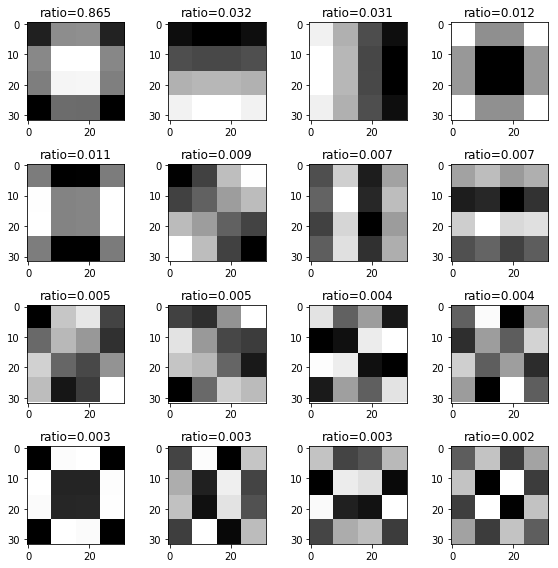

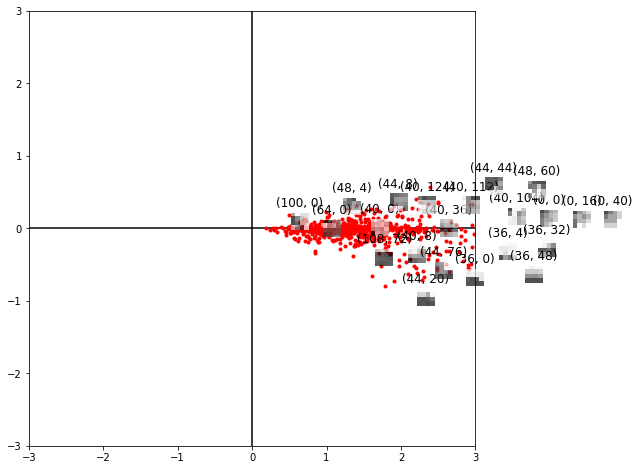

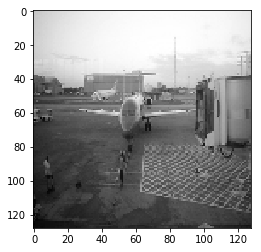

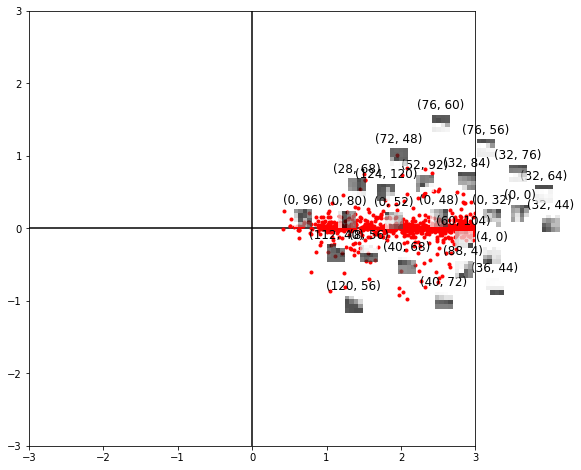

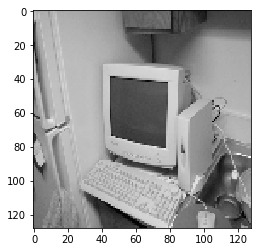

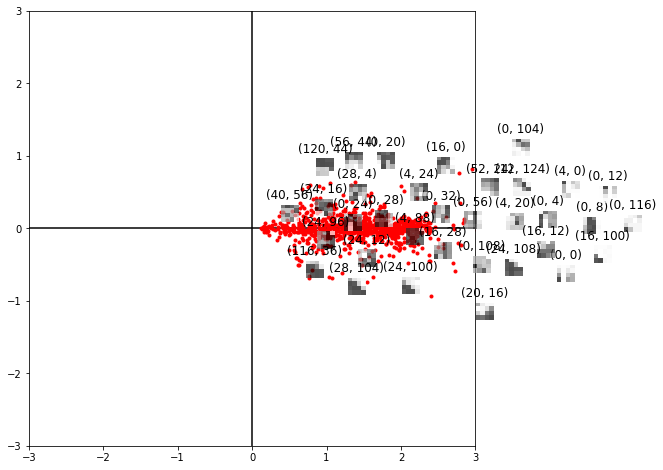

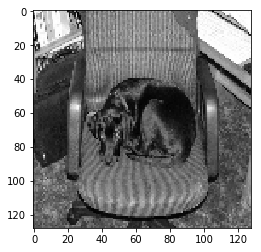

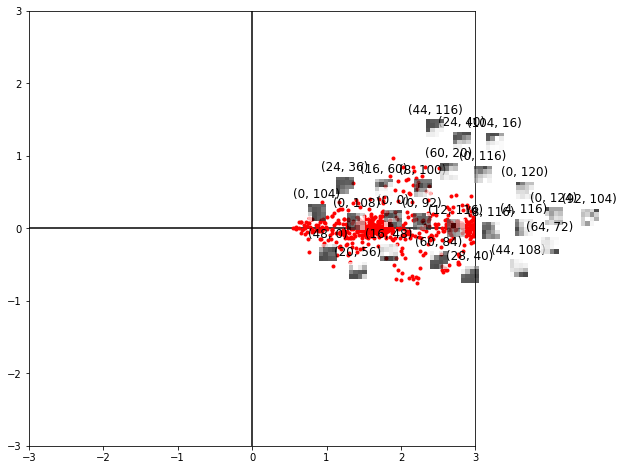

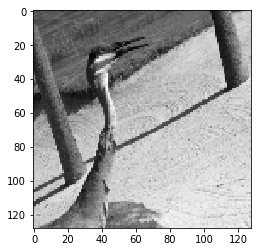

patch shape: (16, 1464, 16)
patch shape: (1464, 16, 16)
patch shape: (23424, 16)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[3.432858627905948, 0.11551478754566859], [3.818407133682433, 0.12787405893567638], [1.9787726179787393, -0.5607038729536881], [2.4178982388011, -0.34341966547442015], [0.9738758831204408, -0.049277287737625686], [1.6274104322628302, 0.20266989972565966], [0.6578045182120836, -0.05318072080813388], [1.3773586333493617, -0.2945794361022119]]
(16, 16, 1)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[2.6461020772925816, 0.09992878433336501], [2.162336799617014, 0.22950909128296162], [1.212770181206009, 0.07521046390611658], [1.8318266707181095, 0.6936138102398044], [2.0901651170293727, -0.30638035718721035], [1.5503382072164729, 0.07745354517619224]]
(16, 16, 1)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[2.42670637170201, -0.42590020581240096], [2.1365747999534315, 0.054769488369

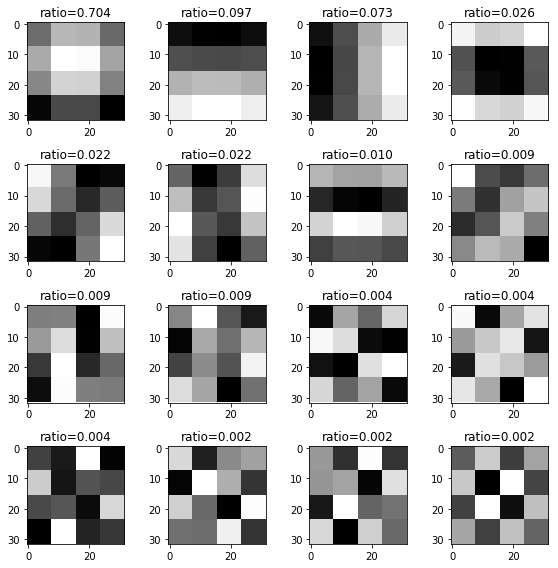

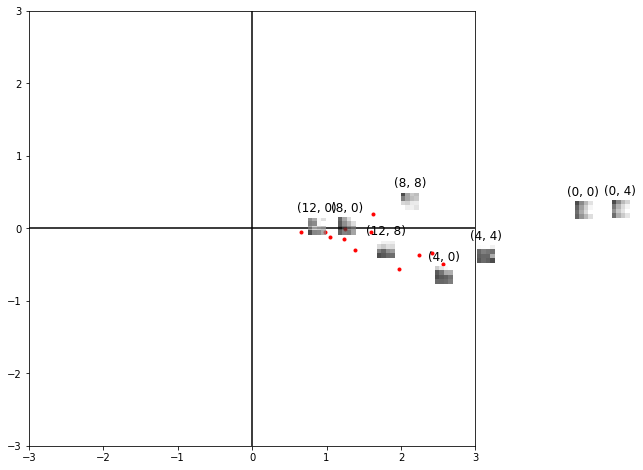

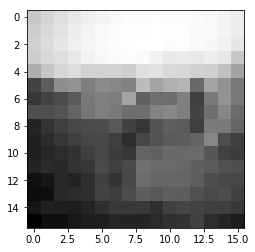

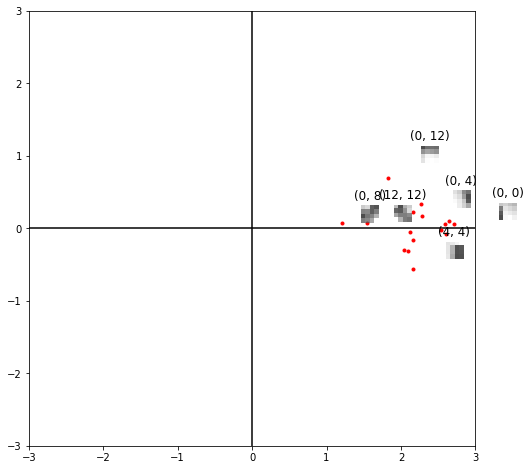

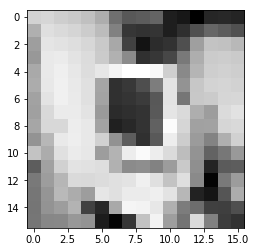

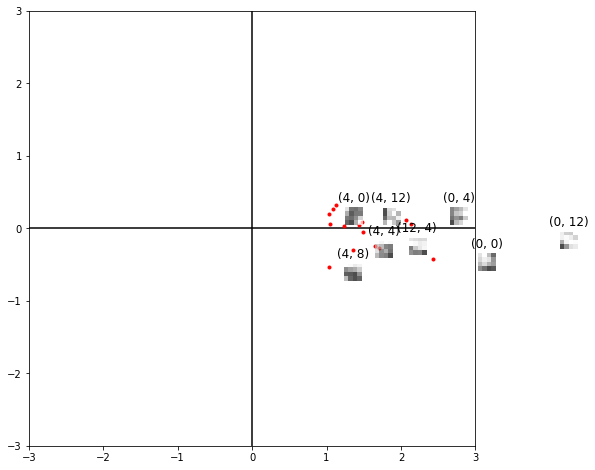

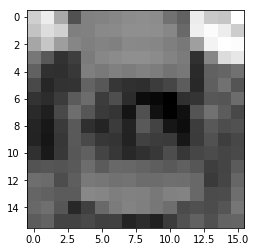

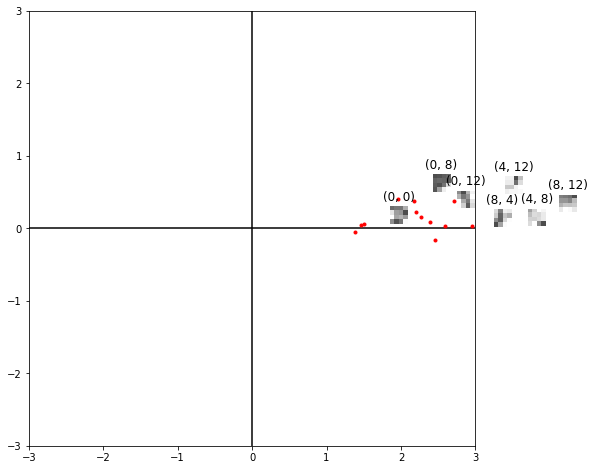

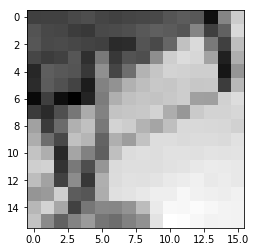

patch shape: (64, 1464, 16)
patch shape: (1464, 64, 16)
patch shape: (93696, 16)
patch shape: (64, 1, 16)
patch shape: (1, 64, 16)
patch shape: (64, 16)
[[3.2714527082686793, 0.07357689589853579], [3.5730621672191174, 0.07367985675048794], [3.8994750991436677, 0.05840177217944406], [2.2184649701184163, -0.7645814834368065], [2.9065793386094163, -0.5852733409407661], [2.5177941283160448, -0.5662751428922619], [3.176727698958878, -0.4002543066299315], [1.2382762812353254, 0.3202609469622314], [1.8856046878487533, -0.27544229577039114], [1.8533089565526923, 0.16351685525835305], [0.912764178673173, -0.07396089611718051], [1.3078282785306001, -0.05863153661348696], [1.4827674905972044, -0.3832471359750705], [0.5264751174052078, -0.04301193093543833]]
(32, 32, 1)
patch shape: (64, 1, 16)
patch shape: (1, 64, 16)
patch shape: (64, 16)
[[2.6148823862304975, 0.020455140804800535], [1.6041977918249102, -0.012149235315552377], [0.9196404682940085, 0.07868672072059466], [1.2151583918639444, 0.355

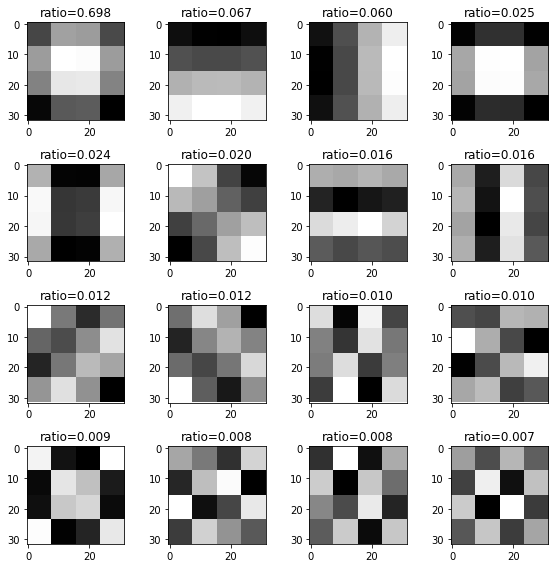

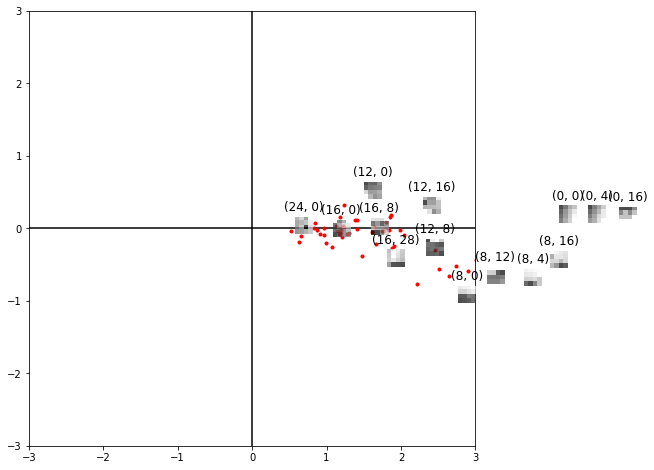

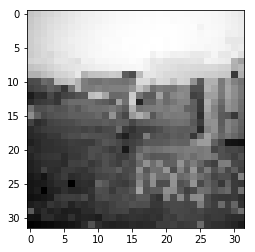

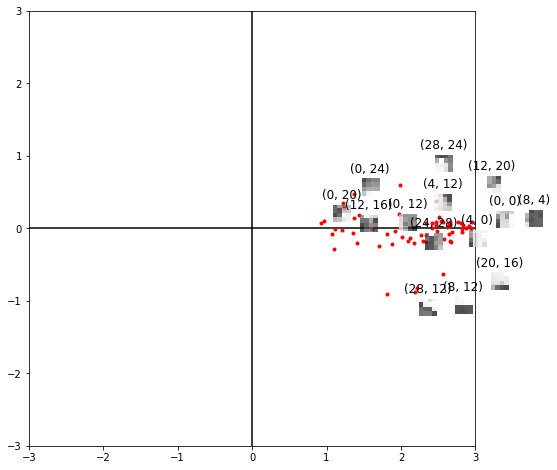

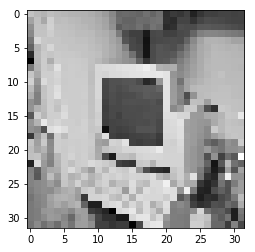

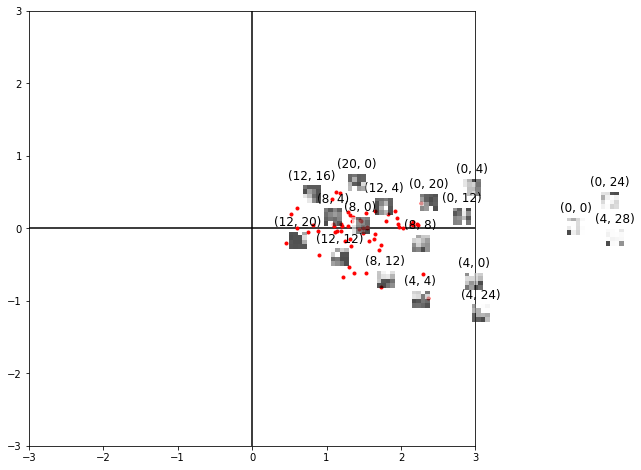

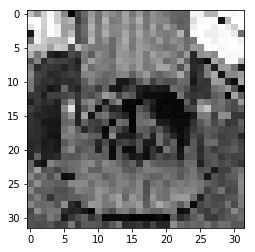

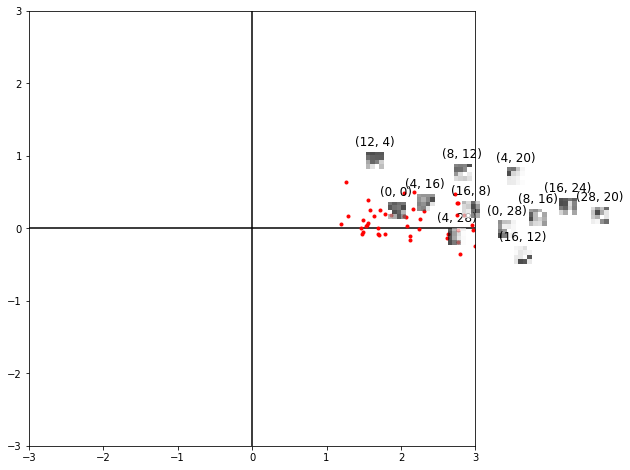

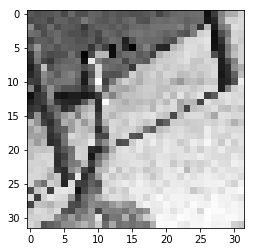

patch shape: (16, 1464, 16)
patch shape: (1464, 16, 16)
patch shape: (23424, 16)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[3.4371804552671374, 0.11873788568288987], [3.8203623845099832, 0.12635400700433416], [1.9397025439539286, -0.6083408183331461], [2.2784959710549364, -0.3644872425816979], [0.9691416903725762, -0.05248377966661281], [1.6549337301242841, 0.19515521081911077], [0.6699647400048578, -0.02322886164818675], [1.3909746821642477, -0.2971974594656664]]
(16, 16, 1)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[2.60617808096199, 0.041068469009956435], [2.1736108538264456, 0.2157026791212868], [1.1790066235224752, 0.06289501280504751], [1.8410011671373119, 0.6941937569063837], [2.0864694288781647, -0.3657776158077633], [1.561305641208385, 0.1305572464433219]]
(16, 16, 1)
patch shape: (16, 1, 16)
patch shape: (1, 16, 16)
patch shape: (16, 16)
[[2.4441988923227562, -0.43515680565137466], [2.1197658911908923, 0.0291808896

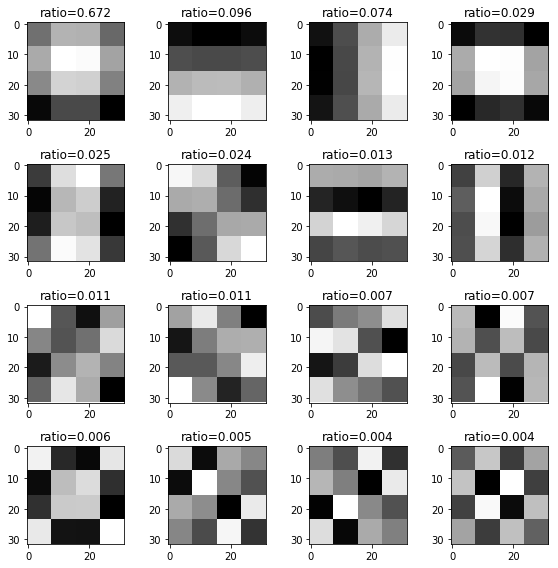

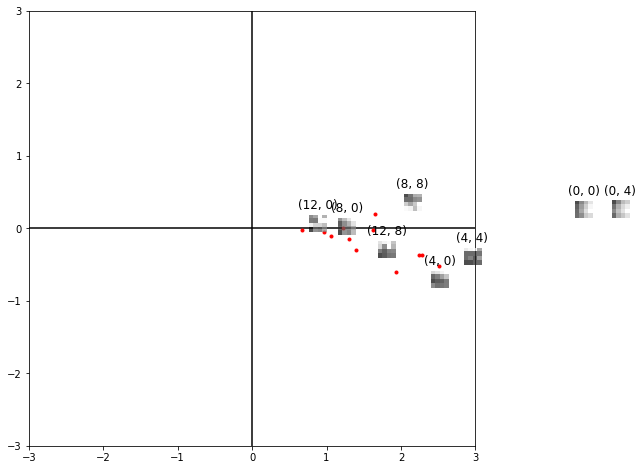

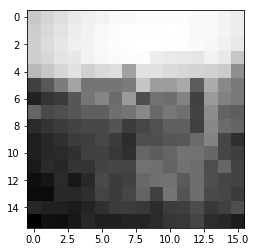

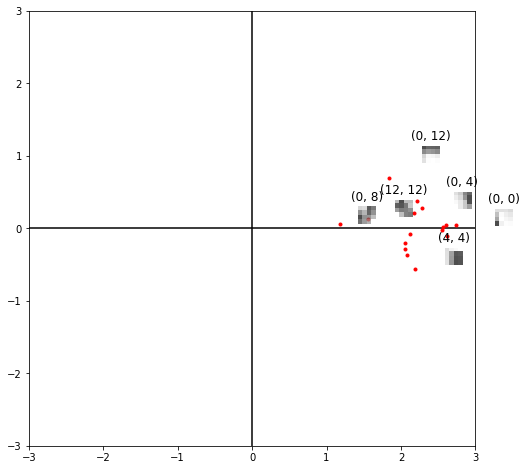

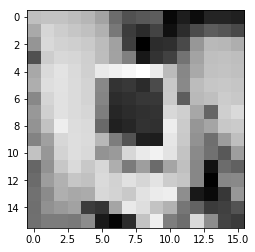

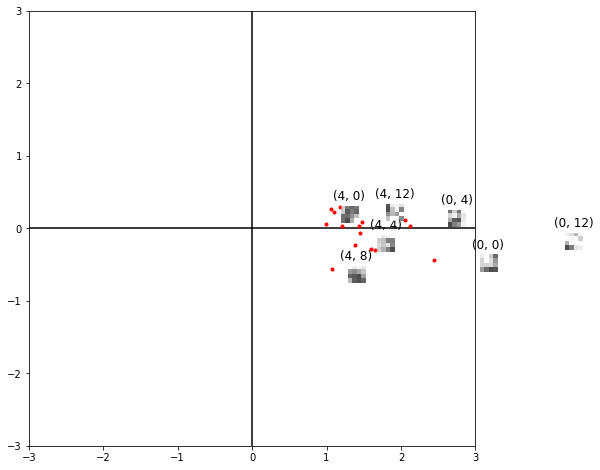

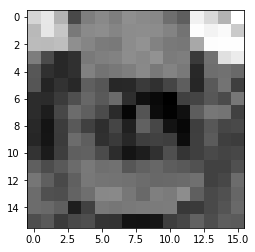

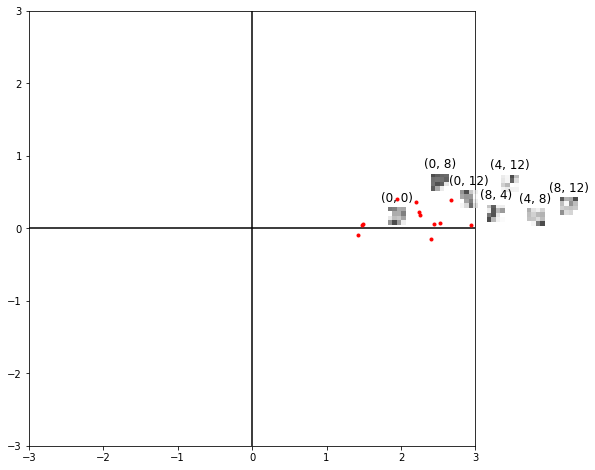

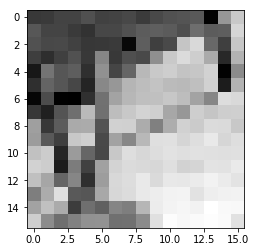

patch shape: (4, 1464, 16)
patch shape: (1464, 4, 16)
patch shape: (5856, 16)
patch shape: (4, 1, 16)
patch shape: (1, 4, 16)
patch shape: (4, 16)
[[2.9569550535941045, -0.43802165884669786], [0.9866608604079724, -0.021538624054420034], [1.509461754929505, 0.011189728605115938]]
(8, 8, 1)
patch shape: (4, 1, 16)
patch shape: (1, 4, 16)
patch shape: (4, 16)
[[2.3977868511341267, 0.30519924779498514], [1.864668578013174, 0.6284717237105056]]
(8, 8, 1)
patch shape: (4, 1, 16)
patch shape: (1, 4, 16)
patch shape: (4, 16)
[[1.7715711661014013, -0.3216971852446493], [2.04490821954989, -0.49026110407071666], [1.3301426520530728, 0.32567263879318264]]
(8, 8, 1)
patch shape: (4, 1, 16)
patch shape: (1, 4, 16)
patch shape: (4, 16)
[[1.6156810423057513, 0.34131569671401213], [2.3948031953849656, 0.6922325474361256], [2.3818357049029806, 0.2877284051188002], [3.2760075938826336, 0.5420492921547967]]
(8, 8, 1)


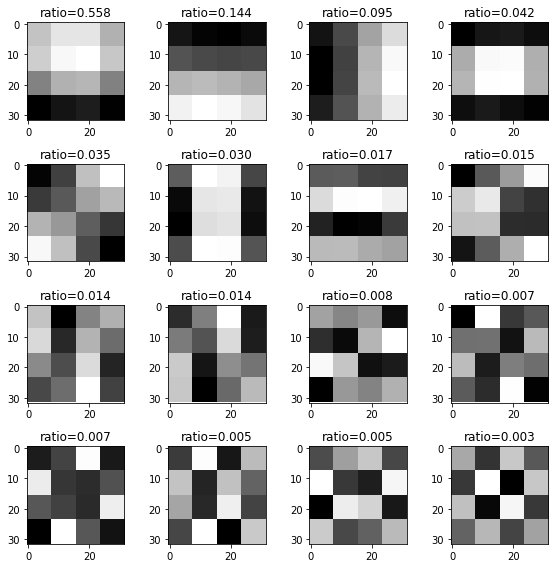

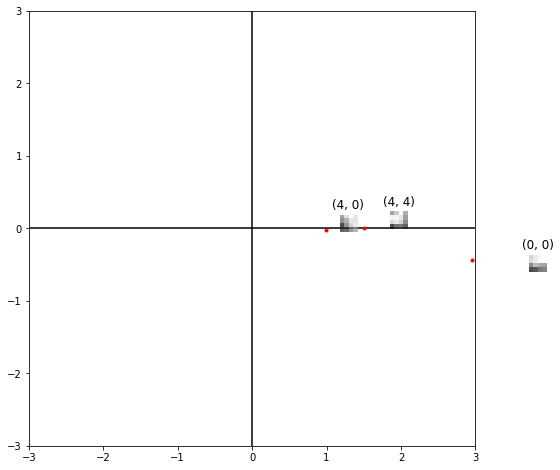

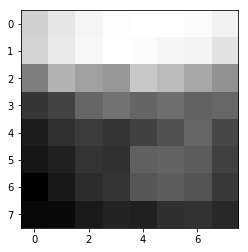

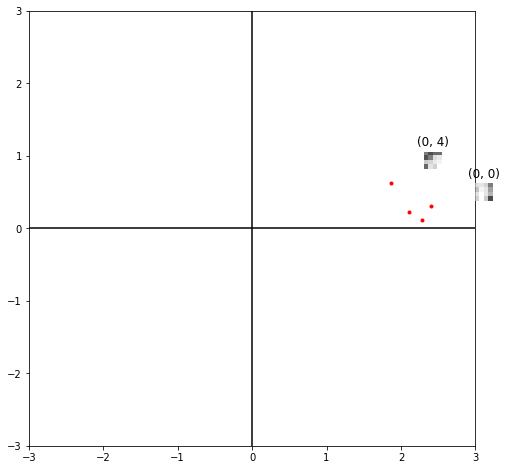

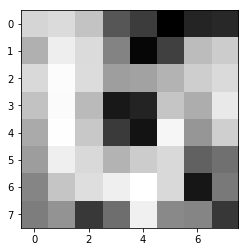

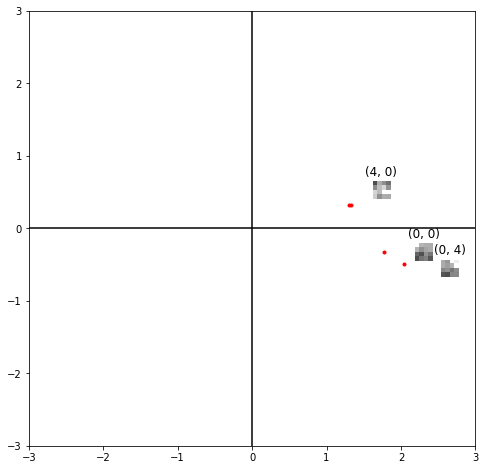

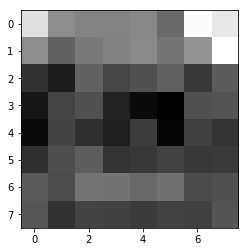

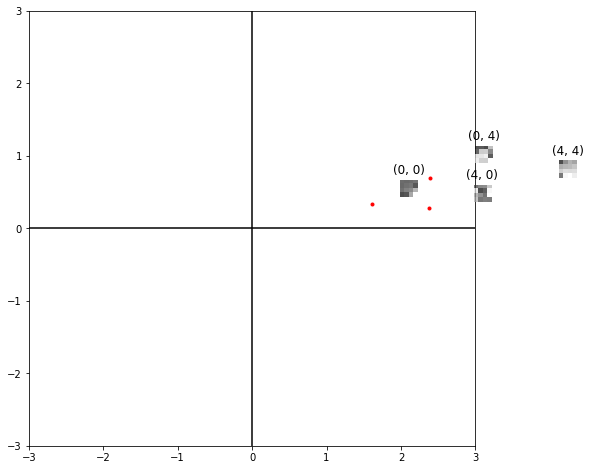

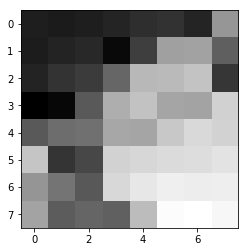

In [343]:
show_pricipal_components(L128, ks=4, fn='_voc128_4x4')
show_pricipal_components(Ld128, ks=4, fn='_voc64_4x4')
show_pricipal_components(L, ks=4, fn='_voc32_4x4')
show_pricipal_components(Ld, ks=4, fn='_voc16_4x4')
show_pricipal_components(Ldd, ks=4, fn='_voc16_4x4')
# show_pricipal_components(L81, ks=3)
# show_pricipal_components(Ld81, ks=3)
# show_pricipal_components(LM, ks=2, fn='_mnist32_2x2')
# show_pricipal_components(LMd, ks=2, fn='_mnist16_2x2')
# show_pricipal_components(LM8, ks=2, fn='_mnist8_2x2')
# show_pricipal_components(L, ks=4)
# show_pricipal_components(A)
# show_pricipal_components(Ad)
# show_pricipal_components(B)
# show_pricipal_components(Bd)

In [307]:
def show_vis_coef(n, m, fn=''):
    plt.figure(figsize=(15, 30))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            plt.subplot(n, m, k + 1)
            plt.axis('off')
            img = cv2.imread('../images/vis%s_coef_%d_%d.png' % (fn, i, j))
            print(img.shape)
            if j == 1:
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
    plt.tight_layout()
    plt.show()

(576, 576, 3)
(288, 432, 3)
(576, 576, 3)
(288, 432, 3)
(576, 576, 3)
(288, 432, 3)
(576, 576, 3)
(288, 432, 3)


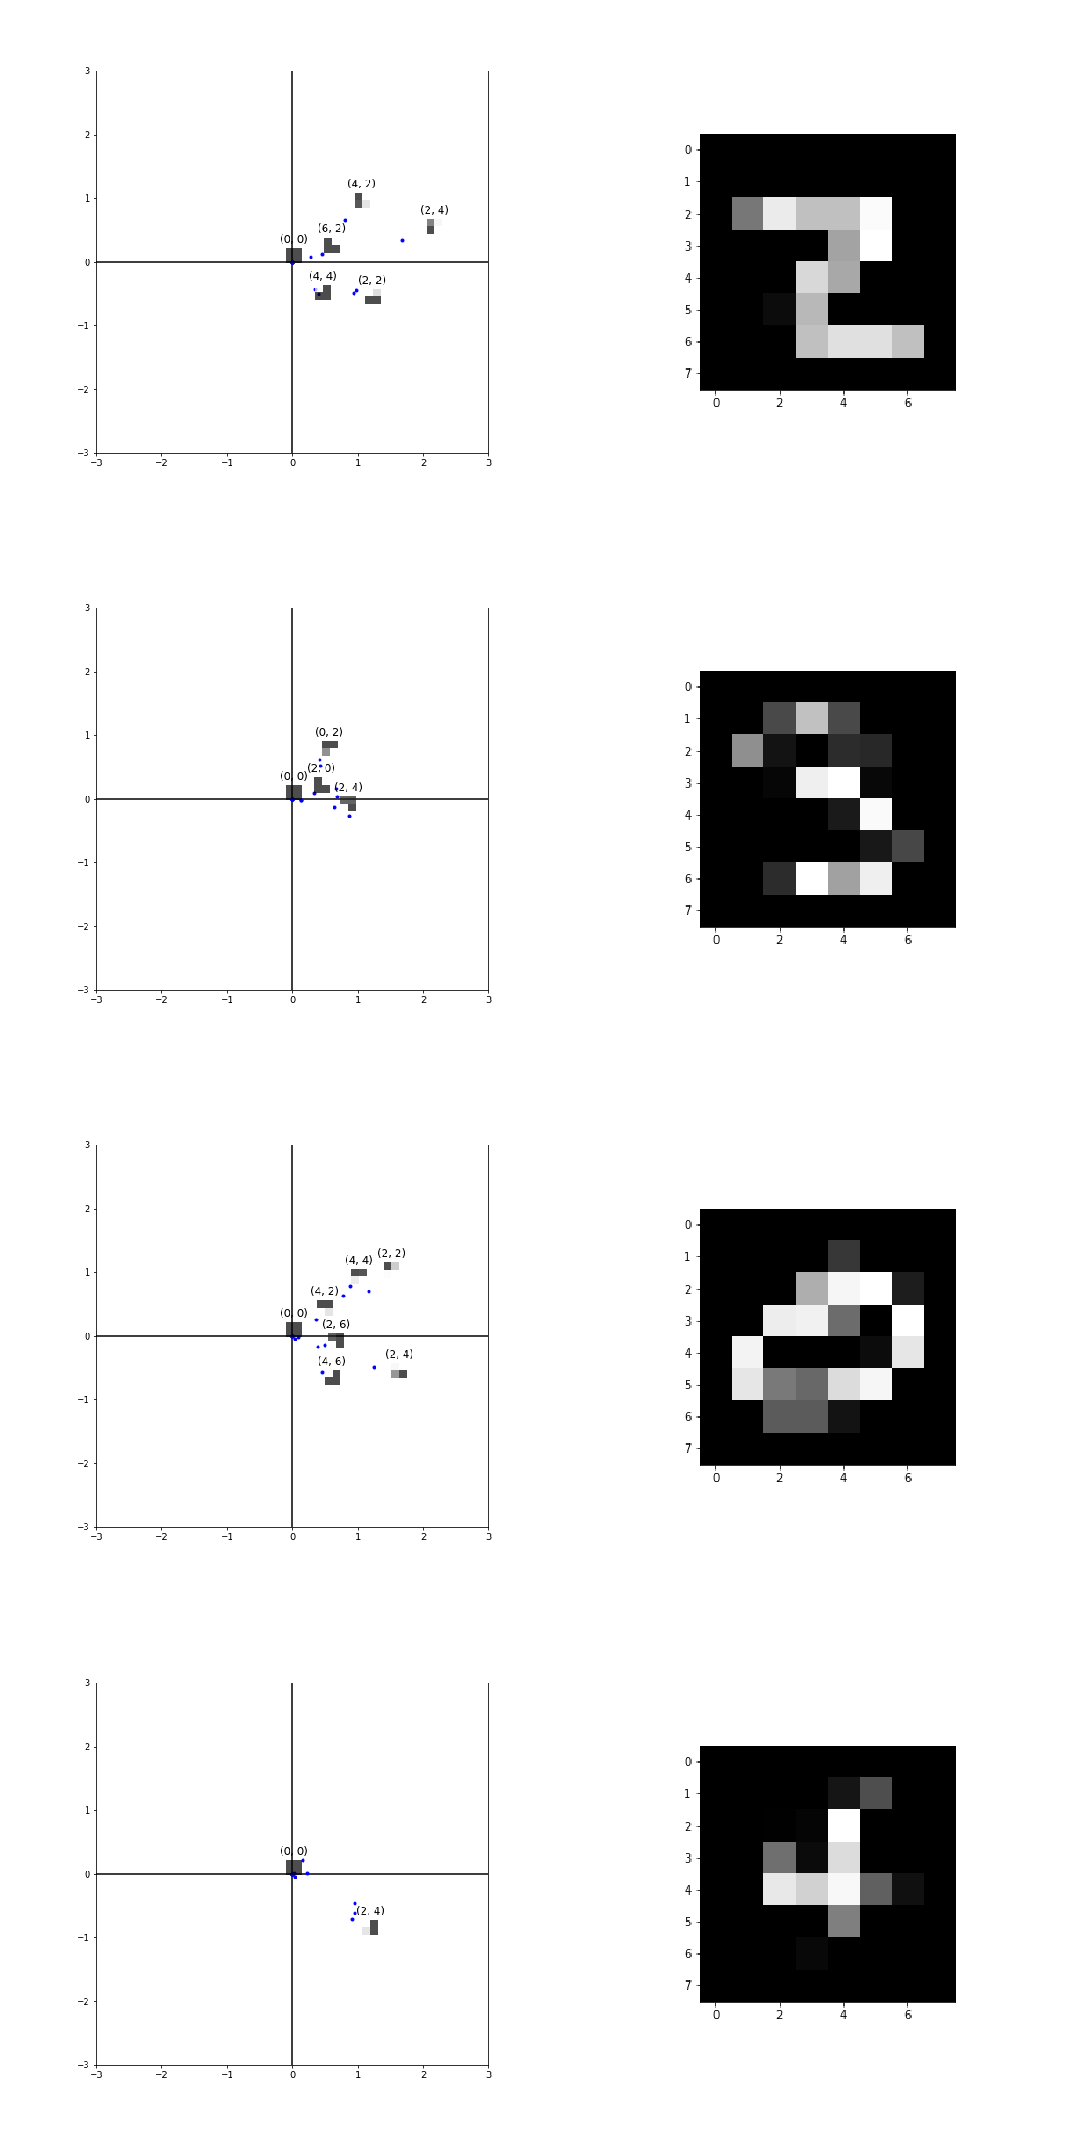

In [323]:
show_vis_coef(4, 2, fn='_mnist8_2x2')

In [326]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

# load MNIST data
data_dir = '../data/'
mnist = read_data_sets(data_dir, reshape=False, validation_size=58000)
print("Input MNIST image shape: " + str(mnist.train.images.shape))

# resize MNIST images to 32x32
train_images = [cv2.resize(img,(8,8)) for img in mnist.train.images]
train_images = np.expand_dims(train_images, axis=3)
print("Resized MNIST images: " + str(train_images.shape))

np.save('../images_mnist_train_8x8.npy', train_images)
np.save('../label_mnist_train.npy', mnist.train.labels)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Input MNIST image shape: (2000, 28, 28, 1)
Resized MNIST images: (2000, 8, 8, 1)


In [336]:
mnist_dir = '../images_mnist_train_32x32.npy'
mnist_32 = np.load(mnist_dir)
LM = mnist_32
LMd = _downsample(LM, 2)
LMd.shape

patch shape: (256, 2000, 4)
patch shape: (2000, 256, 4)
patch shape: (512000, 4)


(2000, 16, 16, 1)

In [321]:
mnist_dir = '../images_mnist_train_8x8.npy'
mnist_8 = np.load(mnist_dir)
LM8 = mnist_8
LM8.shape

(2000, 8, 8, 1)

In [101]:
import voc12

img_list = '/home/yeji/dataset/PASCAL12/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt'
img_dir = '/home/yeji/dataset/PASCAL12/VOCdevkit/VOC2012/JPEGImages'
images_128 = voc12.load_images(img_list, img_dir, (128, 128))
np.save('images_voc12_train_128x128_lab.npy', images_128)

In [348]:
images_128f = images_128 / 255.
L128 = np.expand_dims(images_128f[:,:,:,0], axis=3)
# A = np.expand_dims(images_128f[:,:,:,1], axis=3)
# B = np.expand_dims(images_128f[:,:,:,2], axis=3)
Ld128 = _downsample(L128, 2)
Ld.shape

patch shape: (4096, 1464, 4)
patch shape: (1464, 4096, 4)
patch shape: (5996544, 4)


(1464, 16, 16, 1)

In [102]:
images_128.shape

(1464, 128, 128, 3)

In [122]:
images_81 = voc12.load_images(img_list, img_dir, (81, 81))
np.save('images_voc12_train_81x81_lab.npy', images_81)

In [124]:
images_81.shape

(1464, 81, 81, 3)

In [132]:
images_81f = images_81 / 255.
L81 = np.expand_dims(images_81f[:,:,:,0], axis=3)
# A = np.expand_dims(images_81f[:,:,:,1], axis=3)
# B = np.expand_dims(images_81f[:,:,:,2], axis=3)
Ld81 = _downsample(L81, 9)
Ld.shape

patch shape: (81, 1464, 81)
patch shape: (1464, 81, 81)
patch shape: (118584, 81)


(1464, 16, 16, 1)

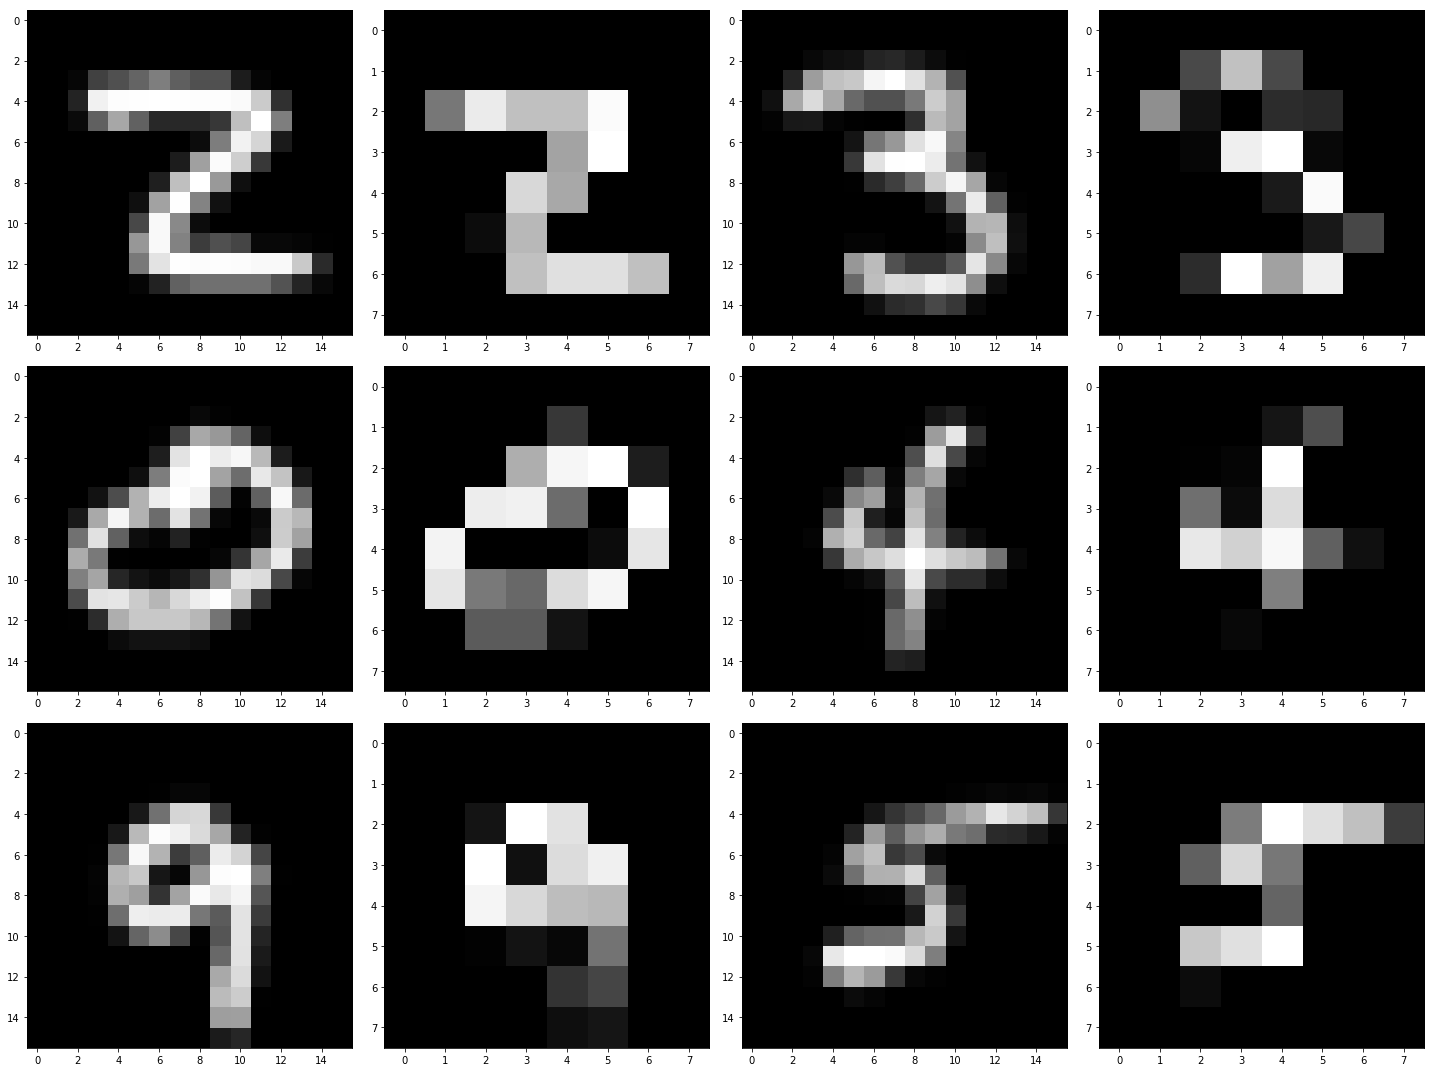

In [352]:
# show orginal images
plt.figure(figsize=(20, 15))
for i in range(3):
    for j in range(2):
        k = i * 4 + j * 2
        plt.subplot(3, 4, k + 1)
        plt.imshow(LMd[i * 2 + j,:,:,0], cmap='gray')
        plt.subplot(3, 4, k + 2)
        plt.imshow(LM8[i * 2 + j,:,:,0], cmap='gray')
plt.tight_layout()
plt.show()
plt.savefig('../images/voc_comp_ds8.png')

In [331]:
from sklearn.svm import SVC

feat = np.load('../feat_mnist8_2x2.npy')
label = np.load('../label_mnist_train.npy')
print(label.shape)
print(feat.shape)
# svc.fit()

(2000,)
(32000, 4)
